# **Neural Network**

In [1]:
# Set the condition

subject_pool = [1, 2, 3, 4, 5, 6, 7, 13] # subject 12 ruins my accuracy ;-;
# subject_list = [1, 3, 4, 5, 6, 7, 13]

# subject_test = [x for x in subject_pool if x not in subject_list][0] # subject 2 is the best

subject_test = 7

subject_list = [subject for subject in subject_pool if subject != subject_test]
# subject_list = [1, 2, 3, 4, 5, 6]

EEG_channel_list = [3] # channel 3 (Fp1) is the best rn

data_scaling = int(3) # scaling 3 (normal scale) is the best rn

excluded_columns = ['Initial_KSS', 'VLF', 'LF', 'HF', 'ORD class', 'class name']

numClasses = 3 # 2:binary, 3:3classes

smote = 0 # 0:No (use class_weight instead), 1:Yes # 0 is better

seed = 42

In [2]:
subject_list

[1, 2, 3, 4, 5, 6, 13]

In [3]:
if data_scaling == 1:
    print('True')

In [4]:
import numpy as np
import tensorflow as tf
import random as python_random

np.random.seed(seed)
python_random.seed(seed)
tf.random.set_seed(seed)

## **1. Import Libraries**

In [5]:
import pandas as pd # pandas is ised to load and manipulate data and for One-Hot Encoding
import numpy as np # data manipulation
import matplotlib.pyplot as plt # matplotlib is for drawing graph
import matplotlib.colors as colors # 
from sklearn.utils import resample # downsample the dataset
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit # split data into training and testing sets
from sklearn.preprocessing import scale # scale and center data
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.svm import SVC # support vector machine classification
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # cross validation
from sklearn.metrics import confusion_matrix # create confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay # draw confusion matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, classification_report
from sklearn.decomposition import PCA # perform PCA to plot the data
from sklearn.compose import ColumnTransformer
from sklearn.utils.class_weight import compute_class_weight

from imblearn.over_sampling import SMOTE


from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

import pickle  
import joblib 


# import matlab data
from scipy.io import loadmat

## **2. Function**

In [6]:
def load_subject_data(subject_number):
    # [INPUT: EEG & ECG data] load the .mat file
    data_path = f'C:/Users/Natchira/Documents/M.eng (from hp)/Thesis/OpenViBE/EEG_ECG_Features/EEG_ECG_Features_subject{subject_number}.mat'
    data = loadmat(data_path)
    ECG_features = data['ECG_features']
    EEG_features = data['EEG_features']
    channelList_pre = data['channelList'][0]
    channelList = []
    for i in range(len(channelList_pre)):
        channelList.append(channelList_pre[i][0])
    
    # [OUTPUT: ORD] load the .xlsx file
    ord_filepath = 'C:/Users/Natchira/Documents/M.eng (from hp)/Thesis/OpenViBE/ORD_labels.xlsx'
    xl = pd.ExcelFile(ord_filepath)
    sheet_name = xl.sheet_names[subject_number-1] # access the subject's sheet by index
    ord_60min = pd.read_excel(ord_filepath, sheet_name=sheet_name)
    
    return ECG_features, EEG_features, ord_60min, channelList

In [7]:
def ECG_dataframe(subject, ECG_features_allcases):
    ECG_features_py = []
    
    # Loop through each struct in the struct array
    for i in range(ECG_features_allcases[subject].shape[0]):  # Adjusted loop for Nx1 struct array
        struct = ECG_features_allcases[subject][i, 0]
        scalar_dict = {
            'Index': struct['Index'][0, 0],
            'VLF': struct['VLF'][0, 0],
            'LF': struct['LF'][0, 0],
            'HF': struct['HF'][0, 0],
            'LFHF': struct['LFHF'][0, 0],
            'pLF': struct['pLF'][0, 0],
            'pHF': struct['pHF'][0, 0]
        }
        ECG_features_py.append(scalar_dict)

    # Convert scalar values to DataFrame
    ECG_features_df = pd.DataFrame(ECG_features_py)
    
    return ECG_features_df

In [8]:
def EEG_dataframe_list(subject, EEG_features_allcases, channelList_allcases):
    
    EEG_features_df_list = []

    numEEGchannels = EEG_features_allcases[subject].shape[1]
    numEEGepochs = EEG_features_allcases[subject].shape[0]
    EEG_featurelist = ['Epoch', 'DeltaRelative', 'ThetaRelative', 'AlphaRelative', 'BetaRelative', 'AlphaBetaRatio', 'TA_BRatio']

    # Assuming struct_array is of shape (139, 12), iterate through each struct
    for channel in range(numEEGchannels):  # for j in range(12)
        channelfeatures = []
        for epoch in range(numEEGepochs):  # for i in range(139)
            epochfeatures = {field: EEG_features_allcases[subject][epoch, channel][field][0,0] for field in EEG_featurelist}
            channelfeatures.append(epochfeatures)
        
        channelfeatures_df = pd.DataFrame(channelfeatures)
        EEG_features_df_list.append(channelfeatures_df)

    # if numEEGchannels != 12:
    #     channelSubject = channelList_allcases[subject]
    #     channelAll = ['o1', 'o2', 'fp1', 'fp2', 'p7', 'p8', 'p3', 'p4', 'f3', 'f4', 't7', 't8']
    #     # for i in range(len(channelAll)):
    #     #     if channelSubject[i] != channelAll[i]:
    #     #         EEG_features_df_list.insert(i, [])
    #     n = 0
    #     for i in range(len(channelAll)):
    #         if channelSubject[i-n] != channelAll[i]:
    #             EEG_features_df_list.insert(i, [])
    #             n += 1
    # Initialize a temporary list to store the new structure
    
    channelSubject = channelList_allcases[subject]
    channelAll = ['o1', 'o2', 'fp1', 'fp2', 'p7', 'p8', 'p3', 'p4', 'f3', 'f4', 't7', 't8']

    temp_EEG_features_list = []
    subject_index = 0

    # Iterate over all possible channels in the complete list
    for channel in channelAll:
        if subject_index < len(channelSubject) and channel == channelSubject[subject_index]:
            # If the channel matches the subject's channel, add the corresponding DataFrame
            temp_EEG_features_list.append(EEG_features_df_list[subject_index])
            subject_index += 1  # Move to the next index in the subject's channel list
        else:
            # If there is no match, add an empty list
            temp_EEG_features_list.append([])

    # Update the original EEG_features_df_list to reflect the new structure
    EEG_features_df_list = temp_EEG_features_list
        
    return EEG_features_df_list

In [9]:
def ord_dataframe(subject, ord_60min_allcases, numClasses):
    
    # 1) ord_60min -> ord_epoch
    ord_epoch = []
    rater = 3

    for i in range(len(ord_60min_allcases[subject]) - 1):
        # Append the current ORD value
        ord_epoch.append(ord_60min_allcases[subject].iloc[i, rater])
        
        # Calculate and append the mean of the current and next ORD values
        mean_ord = np.mean([ord_60min_allcases[subject].iloc[i, rater], ord_60min_allcases[subject].iloc[i + 1, rater]])
        ord_epoch.append(mean_ord)

    # Append the last ORD value since it won't have a subsequent value to average with
    ord_epoch.append(ord_60min_allcases[subject].iloc[-1, rater])

    # Convert the list to a DataFrame and set the column title as 'ord score'
    ord_epoch = pd.DataFrame(ord_epoch, columns=['ORD score'])

    #######################################

    # 2) Simplify to 3 classes
    # ord_epoch['ORD class'] = ord_epoch['ORD score'].apply(lambda x: np.nan if np.isnan(x) else (0 if x <= 2 else (1 if x <= 3 else 2)))
    if numClasses == 3:
        ord_epoch['ORD class'] = ord_epoch['ORD score'].apply(lambda x: np.nan if np.isnan(x) else (int(1) if x <= 2 else (int(2) if x <= 3 else int(3)))) # 3-class
    # ord_epoch['ORD class'] = ord_epoch['ORD score'].apply(lambda x: np.nan if np.isnan(x) else (1 if x <= 2 else (2 if x <= 3 else 3)))
    elif numClasses == 2:
        ord_epoch['ORD class'] = ord_epoch['ORD score'].apply(lambda x: np.nan if np.isnan(x) else (1 if x <= 2 else (2))) # binary


    # Mapping from 'ORD class' to 'class name'
    class_name_mapping = {
        1: 'Alert',
        2: 'Moderately Drowsy',
        3: 'Extremely Drowsy'
    }

    # Add 'class name' column by mapping 'ORD class' to names
    ord_epoch['class name'] = ord_epoch['ORD class'].map(class_name_mapping)

    return ord_epoch
    

In [10]:
def combined_dataframe(EEG_features_df, ECG_features_df, ord_epoch):
    # EEG_features_df (df 139x7): row 10-128, column 1-6
    # ECG_features_df (df 139x7): row 10-128, column 1-6
    # ord_epoch (df 119x3): all row, column 1-2

    # 1) Select the specified rows and columns from each DataFrame
    # EEG_features_selected = EEG_features_df.iloc[10:129, 1:7]  # Rows 10-128, Columns 1-6
    # EEG_features_selected = EEG_features_df.loc[10:129, EEG_features_df.columns != 'Epoch']
    ECG_features_selected = ECG_features_df.iloc[10:129, 1:7]  # Rows 10-128, Columns 1-6
    Epoch_minute = pd.DataFrame({'Epoch_minute': np.linspace(1, 1 + 0.5 * (119 - 1), 119)})
    ord_epoch_selected = ord_epoch.iloc[:, 1:3]  # Columns 1-2

    if not EEG_features_df.empty:
        EEG_features_selected = EEG_features_df.loc[10:129, ~EEG_features_df.columns.str.startswith('Epoch')]



    # 2) Combine these features into a new DataFrame
    # Concatenate EEG and ECG features along the columns
        combined_data = pd.concat([
                                    Epoch_minute.reset_index(drop=True),
                                    EEG_features_selected.reset_index(drop=True), 
                                    ECG_features_selected.reset_index(drop=True),
                                    ord_epoch_selected.reset_index(drop=True)], axis=1)
    else:
        combined_data = pd.concat([
                                    Epoch_minute.reset_index(drop=True),
                                    ECG_features_selected.reset_index(drop=True),
                                    ord_epoch_selected.reset_index(drop=True)], axis=1)        
    # combined_data = combined_data.dropna()

    # Now combined_data contains your inputs (EEG and ECG features) and outputs (ORD class and class name)
    return combined_data

In [11]:
def classwise_accuracy(model, X_test_scaled, y_test):
    # Predict the labels for the test set
    y_pred = model.predict(X_test_scaled)

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Calculate accuracy for each class
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    
    # Define class names mapping
    class_names = {
        1: 'Alert',
        2: 'Moderately Drowsy',
        3: 'Extremely Drowsy'
    }
    
    # Print accuracy for each class
    for i, accuracy in enumerate(class_accuracies, start=1):
        class_name = class_names.get(i, f"Class {i}")
        print(f"Accuracy of {class_name}: {accuracy * 100:.4f}%")

    # Separator
    print("-" * 40)
    
    # Calculate and print F1 scores
    micro_f1 = f1_score(y_test, y_pred, average='micro') # Aggregates the contributions of all classes to compute the average F1 score. Focuses on overall performance.
    weighted_f1 = f1_score(y_test, y_pred, average='weighted') # Computes the F1 score for each class, but uses the number of true instances for each class as weight.
    macro_f1 = f1_score(y_test, y_pred, average='macro') # Computes the F1 score separately for each class and then takes the average. Treats all classes equally.
    
    print(f"Micro-average F1: {micro_f1 * 100:.4f}%") 
    print(f"Weighted-average F1: {weighted_f1 * 100:.4f}%")    
    print(f"Macro-average F1: {macro_f1 * 100:.4f}%")

    # Package the metrics into a dictionary
    metrics = {
        'class_accuracies': class_accuracies,
        'micro_f1': micro_f1,
        'weighted_f1': weighted_f1,
        'macro_f1': macro_f1,
    }

    return metrics

In [12]:
def result_summary(model, X, X_scaled, y):
    # Predict labels on the training data
    y_pred = model.predict(X_scaled)
    original_index = X.index.to_numpy()

    # Create DataFrame with columns
    result_summary = pd.DataFrame({
        "Original Index": original_index,
        "Original Label": y,  # Original labels
        "Predicted Label": y_pred,  # Predicted labels
        "True/False": y_pred == y  # True/False indicator (correctness)
    })

    result_summary = result_summary.sort_values(by="Original Index")
    return result_summary

In [13]:
def perform_PCA(X_train, X_test, n_components, viz_idx):

    pca = PCA()
    pca_scaler = StandardScaler()

    X_train_pca_components = pca.fit_transform(X_train)
    X_train_selected_components = []
    for n in range(0, n_components):
        component = X_train_pca_components[:, n]
        X_train_selected_components.append(component)
    X_train_selected_components = np.array(X_train_selected_components)
    X_train_pca = pca_scaler.fit_transform(X_train_selected_components.T)


    X_test_pca_components = pca.fit_transform(X_test)
    X_test_selected_components = []
    for n in range(0, n_components):
        component = X_test_pca_components[:, n]
        X_test_selected_components.append(component)
    X_test_selected_components = np.array(X_test_selected_components)
    X_test_pca = pca_scaler.fit_transform(X_test_selected_components.T)

    def visualize_comps(viz_idx):
        loading_scores = pd.Series(pca.components_[viz_idx], index=features)
        sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
        top_10_features = sorted_loading_scores[0:10].index.values
        print(f'Visualizing PC {viz_idx}: \n' 
              f'{loading_scores[top_10_features]}')

        per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
        labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
        plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
        plt.xticks()
        plt.ylabel('Percentage of Explained Variance')
        plt.xlabel('Principal Components')
        plt.title('Scree Plot')
        plt.tight_layout()
        plt.show()

    visualize_comps(viz_idx)
    return(X_train_pca, X_test_pca)

# X_train_pca, X_test_pca = perform_PCA(X_train, X_test, n_components = 5, viz_idx = 1)

In [14]:
def accuracy_record(dataframe, model, subject_train, subject_test, EEG_channel_train, X, X_test_scaled, y_test):
    # Assuming classwise_accuracy is defined elsewhere and returns a dictionary with the metrics
    metrics = classwise_accuracy(model, X_test_scaled, y_test)

    if isinstance(X, str) and X == 'pca':
        input_features = 'PCA'
    else:
        input_features = ', '.join(X.columns)

    # Prepare the record to be appended
    record = {
        # 'model': type(model).__name__,  # Get the class name of the model
        'model': str(model),
        'subject_train': subject_train,
        'subject_test': subject_test,
        'channel' : EEG_channel_train,
        'input_features': input_features,  # Column names as a string
        'num_features': model.n_features_in_,
        'class1_accuracy': metrics['class_accuracies'][0] if len(metrics['class_accuracies']) > 0 else None,
        'class2_accuracy': metrics['class_accuracies'][1] if len(metrics['class_accuracies']) > 1 else None,
        'class3_accuracy': metrics['class_accuracies'][2] if len(metrics['class_accuracies']) > 2 else None,
        'micro_f1': metrics['micro_f1'],
        'weighted_f1': metrics['weighted_f1'],
        'macro_f1': metrics['macro_f1'],
    }

    # Append the record to the DataFrame
    record_df = pd.DataFrame.from_records([record])
    dataframe = pd.concat([dataframe, record_df], ignore_index=True)
    
    return dataframe


In [15]:
accuracy_df = pd.DataFrame()

In [16]:
# def accuracy_record(dataframe, model, subject_train, subject_test, X, X_test_scaled, y_test):
#     # store the accuracy in the dataframe

#     # column: model, subject_train, subject_test, input_features, classwise accuracy (3 columns for 3 classes), F1 scores (3 columns for micro, weighted, macro)
#     # append the row with these columns to the dataframe

#     # input_features = X.columns

#     #############################################
#     # Get the metrics from classwise_accuracy
#     metrics = classwise_accuracy(model, X_test_scaled, y_test)

#     # Prepare the record to be appended
#     record = {
#         'model': type(model).__name__,  # Get the class name of the model
#         'subject_train': subject_train,
#         'subject_test': subject_test,
#         'input_features': ', '.join(X.columns),  # Column names as a string
#         'class1_accuracy': metrics['class_accuracies'][0] if len(metrics['class_accuracies']) > 0 else None,
#         'class2_accuracy': metrics['class_accuracies'][1] if len(metrics['class_accuracies']) > 1 else None,
#         'class3_accuracy': metrics['class_accuracies'][2] if len(metrics['class_accuracies']) > 2 else None,
#         'micro_f1': metrics['micro_f1'],
#         'weighted_f1': metrics['weighted_f1'],
#         'macro_f1': metrics['macro_f1'],
#     }

#     # Append the record to the DataFrame
#     # dataframe = dataframe.append(record, ignore_index=True)
#     dataframe = pd.concat([dataframe, record], axis=1)
#     # class_counts_df = pd.concat([class_counts_train, class_counts_test], axis=1, names=['Training Set', 'Testing Set'])

    
#     return dataframe

    

## **3. Import the Data**

##### 2.1 Load the .mat file (input) and .csv file (output)

In [17]:
# subject_list = []

# while True:
#     subject = input('subject: ')
#     if subject == '':
#         break  # Exit the loop if no input is provided and just Enter is pressed.
#     else:
#         try:
#             # Convert the input to an integer and add it to the list
#             subject_number = int(subject)
#             subject_list.append(subject_number)
            
#         except ValueError:
#             # Handle the case where the input is not an integer
#             print("Please enter a valid number or press Enter to finish.")

print("Subjects entered:", subject_list)

subject_train = ''.join(str(x) for x in subject_list)
print(subject_train)


Subjects entered: [1, 2, 3, 4, 5, 6, 13]
12345613


In [18]:
for subject_order in range(len(subject_list)):
    subject = subject_list[subject_order]
    print(subject)


1
2
3
4
5
6
13


In [19]:
# create a list of features (list containing data from each subject in subject_list)

EEG_features_allcases = []
ECG_features_allcases = []
ord_60min_allcases = []
channelList_allcases = []

for subject in subject_list:
    ECG_features, EEG_features, ord_60min, channelList = load_subject_data(subject)
    EEG_features_allcases.append(EEG_features)
    ECG_features_allcases.append(ECG_features)
    ord_60min_allcases.append(ord_60min)
    channelList_allcases.append(channelList)



In [20]:
len(EEG_features_allcases)

7

In [21]:
ord_60min_allcases[0]

,Minutes,Rater 1,Rater 2,Mean
0,1,1.0,1.0,1.0
1,2,1.0,1.0,1.0
2,3,1.0,1.0,1.0
3,4,1.0,2.0,1.5
4,5,1.0,2.0,1.5
5,6,2.0,2.0,2.0
6,7,2.0,2.0,2.0
7,8,2.0,2.0,2.0
8,9,2.0,2.0,2.0
9,10,2.0,2.0,2.0


In [22]:
ECG_field_names = ECG_features.dtype.names
EEG_field_names = EEG_features.dtype.names
print('Loaded Data')
print('ECG Features: ', ECG_field_names) # data stored in 'ECG_features'
print('EEG Features: ', EEG_field_names) # data stored in 'EEG_features'

Loaded Data
ECG Features:  ('Index', 'ECG', 'ECGTimestamps', 'RRI', 'RRITimestamps', 'VLF', 'LF', 'HF', 'LFHF', 'RPeakTimestamps', 'pLF', 'pHF')
EEG Features:  ('Epoch', 'TotalPower', 'AlphaPower', 'AlphaRelative', 'ThetaPower', 'ThetaRelative', 'BetaPower1', 'BetaPower2', 'RBR', 'BetaPower', 'BetaRelative', 'DeltaPower', 'DeltaRelative', 'AlphaBetaRatio', 'TA_BRatio')


In [23]:
for subject_order in range(len(subject_list)): 
    print(subject_order)

0
1
2
3
4
5
6


In [24]:
ord_subject1 = ord_dataframe(0, ord_60min_allcases, numClasses)
ord_subject1['class name'].value_counts()

class name
Extremely Drowsy     44
Alert                37
Moderately Drowsy    35
Name: count, dtype: int64

In [25]:
# EEG_channel_list = []

# while True:
#     channel = input('training channel: ')
#     if channel == '':
#         break  # Exit the loop if no input is provided and just Enter is pressed.
#     else:
#         try:
#             # Convert the input to an integer and add it to the list
#             channel_number = int(channel)
#             EEG_channel_list.append(channel_number)
#         except ValueError:
#             # Handle the case where the input is not an integer
#             print("Please enter a valid number or press Enter to finish.")

# print("Channels entered:", EEG_channel_list)

EEG_channel_train = ''.join(str(x) for x in EEG_channel_list)
print(EEG_channel_train)


3


In [26]:
# # EEG_channel = 3
# EEG_features_df_list = EEG_dataframe_list(0, EEG_features_allcases) # EEG_features_df_list
# EEG_features_df = pd.DataFrame()
# for EEG_channel in EEG_channel_list:
#     EEG_features_append = EEG_features_df_list[EEG_channel-1] # Features from Channel 1
#     EEG_features_df = pd.concat([EEG_features_df, EEG_features_append], axis=1)
# EEG_features_df

In [27]:
# EEG_features_df.iloc[10:15,:]

In [28]:
initial_kss = [7, 6, 5, 5, 5, 5, 5, 7, 6, 4, 5, 6, 7, 6, 5]

In [29]:
# subject = int(input('subject: '))
# initial_kss[subject-1]

In [30]:
# EEG_channel = int(input('EEG Channel: '))
# EEG_channel = 3

combined_data_allcases = pd.DataFrame() # the dataframe to contain data from all subjects

for subject_order in range(len(subject_list)): # loop through subject order
    subject = subject_list[subject_order] # set the "subject no." from subject order
    ECG_features_df = ECG_dataframe(subject_order, ECG_features_allcases) # ECG_features_df of the subject no.
    
    EEG_features_df_list = EEG_dataframe_list(subject_order, EEG_features_allcases, channelList_allcases) # EEG_features_df_list of the subject no.
    # EEG_features_df = EEG_features_df_list[EEG_channel-1] # Features from Channel 1
    EEG_features_df = pd.DataFrame()

    for EEG_channel in EEG_channel_list: # loop through channel in EEG_channel_list
        EEG_features_append = EEG_features_df_list[EEG_channel-1].copy() # Features from 1 channel
        EEG_features_append.columns = [f'{col}_{EEG_channel}' for col in EEG_features_append.columns] # modify the feature names to indicate channel number
        EEG_features_df = pd.concat([EEG_features_df, EEG_features_append], axis=1) # store columns of features from one channel in the dataframe
    
    ord_epoch = ord_dataframe(subject_order, ord_60min_allcases, numClasses) # ord_epoch of the subject no.
    
    print(ord_epoch['class name'].value_counts())

    combined_data = combined_dataframe(EEG_features_df, ECG_features_df, ord_epoch)
    
    combined_data.insert(1, 'Initial_KSS', initial_kss[subject-1])

    # display(EEG_features_df[10:15])
    # display(combined_data)
    combined_data_allcases = pd.concat([combined_data_allcases, combined_data], axis=0)

combined_data_allcases = combined_data_allcases.dropna()

combined_data_allcases['ORD class'] = combined_data_allcases['ORD class'].astype(int)

display(combined_data_allcases)

class name
Extremely Drowsy     44
Alert                37
Moderately Drowsy    35
Name: count, dtype: int64
class name
Alert                48
Moderately Drowsy    29
Extremely Drowsy     23
Name: count, dtype: int64
class name
Moderately Drowsy    65
Alert                42
Extremely Drowsy      4
Name: count, dtype: int64
class name
Alert                70
Moderately Drowsy    43
Name: count, dtype: int64
class name
Alert                99
Moderately Drowsy     7
Name: count, dtype: int64
class name
Alert    110
Name: count, dtype: int64
class name
Moderately Drowsy    65
Alert                28
Extremely Drowsy     26
Name: count, dtype: int64


,Epoch_minute,Initial_KSS,DeltaRelative_3,ThetaRelative_3,AlphaRelative_3,BetaRelative_3,AlphaBetaRatio_3,TA_BRatio_3,VLF,LF,HF,LFHF,pLF,pHF,ORD class,class name
0,1.0,7,0.758710,0.121262,0.040570,0.077795,0.521494,2.080226,1.434614,0.478737,0.204777,2.337852,70.040617,29.959383,1,Alert
1,1.5,7,0.804391,0.089983,0.033200,0.069451,0.478038,1.773666,0.848203,0.921452,0.317672,2.900641,74.363187,25.636813,1,Alert
2,2.0,7,0.814616,0.084756,0.033701,0.062560,0.538707,1.893505,0.834570,1.086668,0.212518,5.113295,83.642210,16.357790,1,Alert
3,2.5,7,0.803604,0.091381,0.036499,0.061415,0.594305,2.082226,0.407440,1.462234,0.219714,6.655165,86.936924,13.063076,1,Alert
4,3.0,7,0.789814,0.078090,0.039198,0.073807,0.531097,1.589140,1.384026,0.578925,0.147688,3.919928,79.674498,20.325502,1,Alert
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,58.0,7,0.866858,0.114499,0.012393,0.008365,1.481427,15.168839,0.445222,1.086824,0.510938,2.127116,68.021653,31.978347,2,Moderately Drowsy
115,58.5,7,0.878538,0.106348,0.011835,0.007597,1.557997,15.557604,0.795086,0.928600,0.329519,2.818049,73.808609,26.191391,2,Moderately Drowsy
116,59.0,7,0.886394,0.098178,0.012114,0.006811,1.778666,16.193405,0.552324,0.723131,0.741039,0.975834,49.388464,50.611536,2,Moderately Drowsy
117,59.5,7,0.866404,0.115475,0.014437,0.007711,1.872383,16.848379,0.351589,1.114647,0.571007,1.952071,66.125473,33.874527,2,Moderately Drowsy


In [31]:
len(EEG_features_df_list)

12

In [32]:
for i in range(len(subject_list)):
    EEG_features_df_list_test = EEG_dataframe_list(1, EEG_features_allcases, channelList_allcases)
    print(len(EEG_features_df_list_test))

12
12
12
12
12
12
12


In [33]:
for i in range(len(subject_list)):
    q = EEG_features_allcases[i].shape[1]
    print(q)

12
12
11
11
12
8
10


## **4. Data Preparation**

In [34]:
combined_data_allcases.head()

,Epoch_minute,Initial_KSS,DeltaRelative_3,ThetaRelative_3,AlphaRelative_3,BetaRelative_3,AlphaBetaRatio_3,TA_BRatio_3,VLF,LF,HF,LFHF,pLF,pHF,ORD class,class name
0,1.0,7,0.758710,0.121262,0.040570,0.077795,0.521494,2.080226,1.434614,0.478737,0.204777,2.337852,70.040617,29.959383,1,Alert
1,1.5,7,0.804391,0.089983,0.033200,0.069451,0.478038,1.773666,0.848203,0.921452,0.317672,2.900641,74.363187,25.636813,1,Alert
2,2.0,7,0.814616,0.084756,0.033701,0.062560,0.538707,1.893505,0.834570,1.086668,0.212518,5.113295,83.642210,16.357790,1,Alert
3,2.5,7,0.803604,0.091381,0.036499,0.061415,0.594305,2.082226,0.407440,1.462234,0.219714,6.655165,86.936924,13.063076,1,Alert
4,3.0,7,0.789814,0.078090,0.039198,0.073807,0.531097,1.589140,1.384026,0.578925,0.147688,3.919928,79.674498,20.325502,1,Alert


In [35]:
type(combined_data_allcases.iloc[1,14])

numpy.int32

In [36]:
ord_type = list(combined_data_allcases['ORD class'].unique()) 

In [37]:
combined_data_allcases.columns

Index(['Epoch_minute', 'Initial_KSS', 'DeltaRelative_3', 'ThetaRelative_3',
       'AlphaRelative_3', 'BetaRelative_3', 'AlphaBetaRatio_3', 'TA_BRatio_3',
       'VLF', 'LF', 'HF', 'LFHF', 'pLF', 'pHF', 'ORD class', 'class name'],
      dtype='object')

In [38]:
# INPUT: Epoch_minute + EEG features + ECG features
# X = combined_data_allcases.iloc[:, 0:13].copy()
# X = combined_data_allcases.iloc[:, [0, 1, 2, 3, 4, 5, 6, 10, 11, 12]].copy()
# X_new = combined_data_allcases['Epoch_minute', 'DeltaRelative','ThetaRelative','AlphaRelative','BetaRelative','AlphaBetaRatio','TA_BRatio','VLF','LF','HF','LFHF','pLF','pHF'].copy()

X = combined_data_allcases.loc[:, ~combined_data_allcases.columns.isin(excluded_columns)].copy()

print(X.shape)
X.head()

(775, 10)


,Epoch_minute,DeltaRelative_3,ThetaRelative_3,AlphaRelative_3,BetaRelative_3,AlphaBetaRatio_3,TA_BRatio_3,LFHF,pLF,pHF
0,1.0,0.758710,0.121262,0.040570,0.077795,0.521494,2.080226,2.337852,70.040617,29.959383
1,1.5,0.804391,0.089983,0.033200,0.069451,0.478038,1.773666,2.900641,74.363187,25.636813
2,2.0,0.814616,0.084756,0.033701,0.062560,0.538707,1.893505,5.113295,83.642210,16.357790
3,2.5,0.803604,0.091381,0.036499,0.061415,0.594305,2.082226,6.655165,86.936924,13.063076
4,3.0,0.789814,0.078090,0.039198,0.073807,0.531097,1.589140,3.919928,79.674498,20.325502


In [39]:
X.columns

Index(['Epoch_minute', 'DeltaRelative_3', 'ThetaRelative_3', 'AlphaRelative_3',
       'BetaRelative_3', 'AlphaBetaRatio_3', 'TA_BRatio_3', 'LFHF', 'pLF',
       'pHF'],
      dtype='object')

In [40]:
# OUTPUT: ORD class
y = combined_data_allcases['ORD class'].copy()
print(y.shape)
y.head()

(775,)


0    1
1    1
2    1
3    1
4    1
Name: ORD class, dtype: int32

In [41]:
# Specify seed

seed = 42

- **Split #1**

In [42]:
# # Data Splitting

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, train_size = 0.8)


In [43]:
# # Count class labels in training data
# class_counts_train = y_train.value_counts()

# # Count class labels in testing data
# class_counts_test = y_test.value_counts()

# # Add 'Total' row for training and testing sets
# total_train = class_counts_train.sum()
# total_test = class_counts_test.sum()
# class_counts_df = pd.concat([class_counts_train, class_counts_test], axis=1, names=['Training Set', 'Testing Set'])
# class_counts_df.loc['Total'] = [total_train, total_test]  # Add total row

# # Add 'Total' column for class-wise sum
# class_counts_df['Total'] = class_counts_df.sum(axis=1)  # Add total column

# # Print the DataFrame
# print(class_counts_df)

- **Split #2**

In [44]:
# # Split ratio (modify if needed)
# train_size = 0.8

# # Group data by class label
# grouped_data = y.to_frame('ORD class').join(X)  # Combine features and labels
# grouped_by_class = grouped_data.groupby('ORD class')

# # Define empty lists to store training and testing sets
# X_train, X_test, y_train, y_test = [], [], [], []

# # Sample from each class and append to respective lists
# for class_label, class_data in grouped_by_class:
#   # Sample data for training and testing sets (modify sample size if needed)
#   train_data = class_data.sample(int(len(class_data) * train_size))
#   test_data = class_data.drop(train_data.index)

#   X_train.append(train_data.drop('ORD class', axis=1))  # Features for training set
#   y_train.append(train_data['ORD class'])  # Labels for training set
#   X_test.append(test_data.drop('ORD class', axis=1))  # Features for testing set
#   y_test.append(test_data['ORD class'])  # Labels for testing set

# # Concatenate lists into DataFrames
# X_train = pd.concat(X_train)
# X_test = pd.concat(X_test)
# y_train = pd.concat(y_train)
# y_test = pd.concat(y_test)

# # Print the shapes of training and testing sets (optional)
# print(f"X_train shape: {X_train.shape}")
# print(f"X_test shape: {X_test.shape}")
# print(f"y_train shape: {y_train.shape}")
# print(f"y_test shape: {y_test.shape}")

In [45]:
# # Count class labels in training data
# class_counts_train = y_train.value_counts()

# # Count class labels in testing data
# class_counts_test = y_test.value_counts()

# # Add 'Total' row for training and testing sets
# total_train = class_counts_train.sum()
# total_test = class_counts_test.sum()
# class_counts_df = pd.concat([class_counts_train, class_counts_test], axis=1, names=['Training Set', 'Testing Set'])
# class_counts_df.loc['Total'] = [total_train, total_test]  # Add total row

# # Add 'Total' column for class-wise sum
# class_counts_df['Total'] = class_counts_df.sum(axis=1)  # Add total column

# # Print the DataFrame
# print(class_counts_df)

In [46]:
# X_test

- **Split #3**

In [47]:
# Split ratio (modify if needed)
train_size = 0.8

# Set the random seed (modify as needed)
random_seed = seed  # Example seed value

X_reset = X.reset_index(drop=True, inplace=False)
y_reset = y.reset_index(drop=True, inplace=False)

# Group data by class label
# grouped_data = y.to_frame('ORD class').join(X)  # Combine features and labels
grouped_data = pd.concat([y_reset, X_reset], axis=1)
grouped_by_class = grouped_data.groupby('ORD class')

# Define empty lists to store training and testing sets
X_train, X_test, y_train, y_test = [], [], [], []

# Sample from each class and append to respective lists
for class_label, class_data in grouped_by_class:
    
    # Sample data for training and testing sets (modify sample size if needed)
    train_data = class_data.sample(int(len(class_data) * train_size), random_state=random_seed)
    test_data = class_data.drop(train_data.index)

    X_train.append(train_data.drop('ORD class', axis=1))  # Features for training set
    y_train.append(train_data['ORD class'])  # Labels for training set
    X_test.append(test_data.drop('ORD class', axis=1))  # Features for testing set
    y_test.append(test_data['ORD class'])  # Labels for testing set

# Concatenate lists into DataFrames
X_train = pd.concat(X_train)
X_test = pd.concat(X_test)
y_train = pd.concat(y_train)
y_test = pd.concat(y_test)

X_train = X_train.sample(frac=1, random_state=seed)
y_train = y_train.loc[X_train.index] # Use the index of the shuffled X_train to reorder y_train

# Print the shapes of training and testing sets (optional)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (619, 10)
X_test shape: (156, 10)
y_train shape: (619,)
y_test shape: (156,)


In [48]:
train_data.index

Index([200, 112, 722,  90, 708, 711, 202, 114,  82,  72, 103, 702, 185,  98,
       182,  76,  94,  84, 718, 700, 187, 319, 317,  87, 111, 105,  81, 707,
        83, 203, 724, 102, 100, 715,  77, 183, 318, 107,  88, 699, 106,  79,
       193,  99,  91, 706,  97, 191,  85,  96,  75,  89, 110,  80, 703,  78,
       705, 108, 713, 194, 725, 192, 115, 188, 204, 184, 316, 199, 723, 704,
       113, 196, 186, 712, 195, 104, 720],
      dtype='int64')

In [49]:
X_test

,Epoch_minute,DeltaRelative_3,ThetaRelative_3,AlphaRelative_3,BetaRelative_3,AlphaBetaRatio_3,TA_BRatio_3,LFHF,pLF,pHF
1,1.5,0.804391,0.089983,0.033200,0.069451,0.478038,1.773666,2.900641,74.363187,25.636813
13,7.5,0.810045,0.092786,0.036629,0.059015,0.620668,2.192916,3.774879,79.057061,20.942939
20,11.0,0.818136,0.086354,0.029818,0.059806,0.498580,1.942488,7.751858,88.573855,11.426145
21,11.5,0.846425,0.075125,0.028597,0.046903,0.609710,2.211415,5.051168,83.474265,16.525735
34,19.5,0.826073,0.082665,0.034013,0.053648,0.634014,2.174898,1.277845,56.098855,43.901145
...,...,...,...,...,...,...,...,...,...,...
709,27.5,0.900981,0.086015,0.008635,0.007163,1.205574,13.213932,1.682892,62.726796,37.273204
714,30.0,0.883065,0.086104,0.014782,0.016568,0.892216,6.089350,5.728945,85.138829,14.861171
717,31.5,0.895758,0.089625,0.009843,0.006567,1.498790,15.145866,2.683645,72.852977,27.147023
719,32.5,0.883694,0.102425,0.010042,0.006639,1.512561,16.939547,1.587883,61.358372,38.641628


- **SMOTE**

In [50]:
if smote == 1:
    smote = SMOTE(random_state=seed)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    X_train = X_train.sample(frac=1, random_state=seed)
    y_train = y_train.loc[X_train.index] # Use the index of the shuffled X_train to reorder y_train

In [51]:
# Count class labels in training data
class_counts_train = y_train.value_counts()

# Count class labels in testing data
class_counts_test = y_test.value_counts()

# Add 'Total' row for training and testing sets
total_train = class_counts_train.sum()
total_test = class_counts_test.sum()
class_counts_df = pd.concat([class_counts_train, class_counts_test], axis=1, names=['Training Set', 'Testing Set'])
class_counts_df.loc['Total'] = [total_train, total_test]  # Add total row

# Add 'Total' column for class-wise sum
class_counts_df['Total'] = class_counts_df.sum(axis=1)  # Add total column

# Print the DataFrame
print(class_counts_df)

           count  count  Total
ORD class                     
1            347     87    434
2            195     49    244
3             77     20     97
Total        619    156    775


- **Scaling**

In [54]:
if data_scaling == 0:
    X_train_scaled = X_train
    X_test_scaled = X_test

####################################################

# Data Scaling 1
elif data_scaling == 1:
    X_train_scaled = scale(X_train)
    X_test_scaled = scale(X_test)

####################################################

# Data Scaling 2

elif data_scaling == 2:
    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

####################################################

# Data Scaling 3

elif data_scaling == 3:
    # Columns not to scale
    columns_not_to_scale = ['Epoch_minute']

    # Create a ColumnTransformer which scales all other columns except the specified
    scaler = ColumnTransformer([
        ('passthrough', 'passthrough', columns_not_to_scale)
    ], remainder=StandardScaler())

    # Fit and transform the data
    X_train_scaled = scaler.fit_transform(X_train)

    # Define the order of columns in the transformed data based on the transformer
    transformed_columns = columns_not_to_scale + [col for col in X_train.columns if col not in columns_not_to_scale]

    # Convert array back to DataFrame (optional, for better readability and further processing)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=transformed_columns)

    # Reorder the columns to match the original DataFrame's order
    X_train_scaled = X_train_scaled[X_train.columns]

    # Perform on test set
    X_test_scaled = scaler.transform(X_test)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=transformed_columns)
    X_test_scaled = X_test_scaled[X_test.columns]

####################################################

# Data Scaling 4

elif data_scaling == 4:
    columns_not_to_scale = ['Epoch_minute']

    def scale_down(data):
        return data * 0.1

    # Create a transformer for scaling down by multiplying by 0.1
    scale_down_transformer = FunctionTransformer(scale_down)

    # Create a ColumnTransformer which scales all other columns except the specified
    scaler = ColumnTransformer([
        ('scale_down', scale_down_transformer, columns_not_to_scale)
    ], remainder=StandardScaler())

    # Fit and transform the training data
    X_train_scaled = scaler.fit_transform(X_train)

    # Define the order of columns in the transformed data based on the transformer
    # Note: This assumes scaler retains the column order which it does not always do by default
    transformed_columns = columns_not_to_scale + [col for col in X_train.columns if col not in columns_not_to_scale]

    # Convert array back to DataFrame (optional, for better readability and further processing)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=transformed_columns)

    # Reorder the columns to match the original DataFrame's order
    X_train_scaled = X_train_scaled[X_train.columns]

    # Transform the test data
    X_test_scaled = scaler.transform(X_test)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=transformed_columns)
    X_test_scaled = X_test_scaled[X_test.columns]

In [55]:
# scaler_save = scaler.fit(X_train)

# with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{''.join(str(x) for x in subject_list)}_standard_scaler.pkl', "wb") as f:
#     pickle.dump(scaler_save, f)

In [56]:
X_train.head()

,Epoch_minute,DeltaRelative_3,ThetaRelative_3,AlphaRelative_3,BetaRelative_3,AlphaBetaRatio_3,TA_BRatio_3,LFHF,pLF,pHF
492,27.0,0.590848,0.046356,0.047907,0.267144,0.179329,0.352853,9.000206,90.000206,9.999794
79,42.0,0.760579,0.096221,0.035135,0.078023,0.450316,1.683554,4.993842,83.316211,16.683789
672,9.0,0.888088,0.099040,0.009795,0.004988,1.963676,21.819761,1.583352,61.290600,38.709400
611,35.0,0.747697,0.076211,0.041811,0.124094,0.336927,0.951061,2.937524,74.603332,25.396668
561,8.5,0.747272,0.106883,0.045162,0.095885,0.471003,1.585706,3.277075,76.619534,23.380466


In [57]:
y_train.head()

492    1
79     3
672    1
611    1
561    1
Name: ORD class, dtype: int32

## **5. Neural Network**

### **5.1 'categorical_crossentropy'**

- **Import Dependencies**

In [58]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, LSTM, BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import accuracy_score

- **Build and Compile Model**

In [59]:
encoder = OneHotEncoder(categories=[ord_type], sparse_output=False)

In [60]:
encoder.fit(pd.DataFrame(y_train))

OneHotEncoder(categories=[[1, 2, 3]], sparse_output=False)

In [61]:
y_train_encoded = encoder.transform(pd.DataFrame(y_train))
# y_train_encoded = pd.get_dummies(y_train).values
y_test_encoded = encoder.transform(pd.DataFrame(y_test))


In [62]:
numInputlayers = len(X_train.columns)

In [63]:
np.random.seed(seed)
python_random.seed(seed)
tf.random.set_seed(seed)

In [64]:
len(ord_type)

3

In [65]:
model = Sequential()

model.add(Dense(units=numInputlayers, activation='relu', input_dim=len(X_train.columns))) # Input Layer
model.add(BatchNormalization())
model.add(Dense(units=16, activation='relu')) # Hidden Layer
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(units=16, activation='relu')) # Hidden Layer
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(units=len(ord_type), activation='softmax')) # Output Layer



c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [66]:
optimizer = Adam(learning_rate=0.01)

model.compile(
              loss='categorical_crossentropy',
              # loss=categorical_focal_loss(gamma=2.0, alpha=0.25), 
              optimizer=optimizer, 
              metrics=['accuracy']
              )

In [67]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 777 (3.04 KB)

 Trainable params: 693 (2.71 KB)

 Non-trainable params: 84 (336.00 B)

- **Fit, Predict and Evaluate**

In [68]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}

In [69]:
history = model.fit(X_train_scaled, y_train_encoded, 
                    class_weight=class_weights_dict,
                    epochs=200, 
                    # batch_size=32, 
                    validation_split=0.05)
                    # validation_data=(X_test_scaled, y_test_encoded))

Epoch 1/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4896 - loss: 1.0324 - val_accuracy: 0.6452 - val_loss: 0.8612
Epoch 2/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6326 - loss: 0.8448 - val_accuracy: 0.6452 - val_loss: 0.8333
Epoch 3/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6907 - loss: 0.7135 - val_accuracy: 0.7419 - val_loss: 0.7246
Epoch 4/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6912 - loss: 0.7074 - val_accuracy: 0.7742 - val_loss: 0.6590
Epoch 5/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6683 - loss: 0.7461 - val_accuracy: 0.8710 - val_loss: 0.5310
Epoch 6/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7003 - loss: 0.6946 - val_accuracy: 0.8710 - val_loss: 0.4623
Epoch 7/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6923 - loss: 0.6771 - val_accuracy: 0.8387 - val_loss: 0.5052
Epoch 8/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7168 - loss: 0.6698 - val_accuracy: 0.8710 - v

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


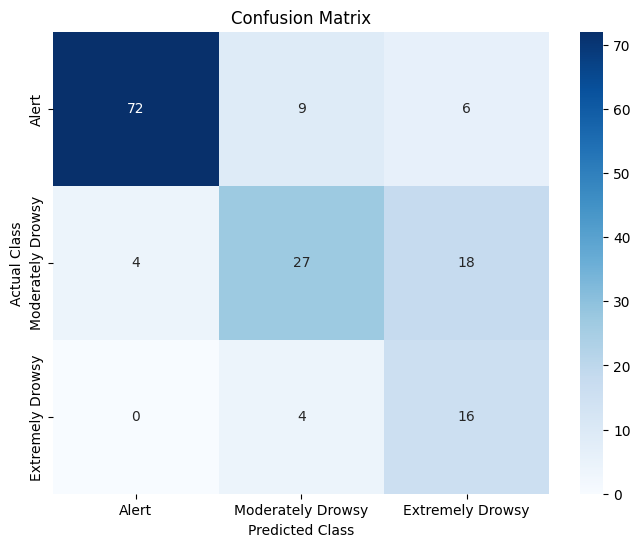

In [70]:
y_hat = model.predict(X_test_scaled)
y_hat_classes = np.argmax(y_hat, axis=1)
y_test_compare = y_test-1

import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(y_test_compare, y_hat_classes)
def plot_confusion_matrix(cm, class_names):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()

if numClasses == 3:
    class_names = ['Alert', 'Moderately Drowsy', 'Extremely Drowsy']
elif numClasses == 2:
    class_names = ['Alert', 'Drowsy']

# Assuming 'class_names' is a list of your class names, such as class_names = ['Class1', 'Class2', 'Class3']
plot_confusion_matrix(cm, class_names)

In [71]:
y_test-1

1      0
13     0
20     0
21     0
34     0
      ..
709    2
714    2
717    2
719    2
721    2
Name: ORD class, Length: 156, dtype: int32

In [72]:
y_test_encoded = encoder.transform(pd.DataFrame(y_test))
# y_test_encoded = pd.get_dummies(y_test).values

In [73]:
# Predict the test set
predictions = model.predict(X_test_scaled)
predicted_classes = np.argmax(predictions, axis=1)


# True classes (convert from one-hot if necessary)
true_classes = np.argmax(y_test_encoded, axis=1)  # Make sure y_encoded is not class indices

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:\n", conf_matrix)

# Class-wise accuracy
class_wise_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
print("Class-wise Accuracy:", class_wise_accuracy)

# Detailed classification report
if numClasses == 3:
    report = classification_report(true_classes, predicted_classes, target_names=['Class0', 'Class1', 'Class2'])
elif numClasses == 2:
    report = classification_report(true_classes, predicted_classes, target_names=['Class0', 'Class1'])

print(report)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
Confusion Matrix:
 [[72  9  6]
 [ 4 27 18]
 [ 0  4 16]]
Class-wise Accuracy: [0.82758621 0.55102041 0.8       ]
              precision    recall  f1-score   support

      Class0       0.95      0.83      0.88        87
      Class1       0.68      0.55      0.61        49
      Class2       0.40      0.80      0.53        20

    accuracy                           0.74       156
   macro avg       0.67      0.73      0.67       156
weighted avg       0.79      0.74      0.75       156



5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7748 - loss: 0.6913 
Test Accuracy: 0.7371794581413269, Test Loss: 0.7529764175415039


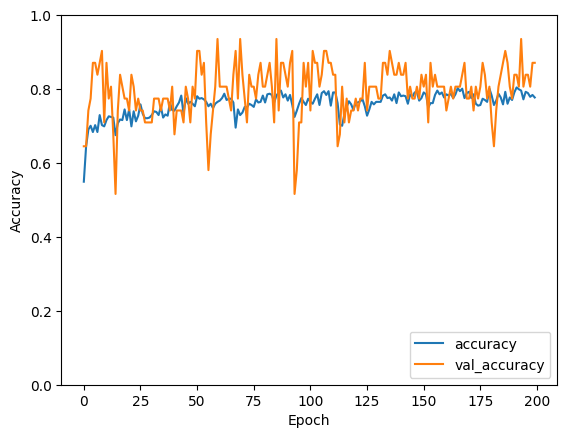

In [74]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_scaled, y_test_encoded)
print(f"Test Accuracy: {test_acc}, Test Loss: {test_loss}")

# Plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

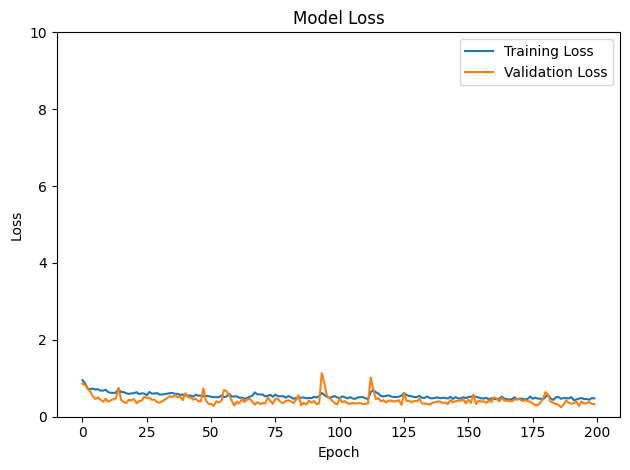

In [75]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss') 
plt.ylim([0, 10])
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

### **5.2 'sparse_categorical_crossentropy'**

- **Import Dependencies**

In [76]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, LSTM
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical

In [77]:
y_train_encoded2 = to_categorical(y_train-1, num_classes=3)
y_test_encoded2 = to_categorical(y_test-1, num_classes=3)

- **Build and Compile Model**

In [78]:
np.random.seed(seed)
python_random.seed(seed)
tf.random.set_seed(seed)

In [79]:
model2 = Sequential()
model2.add(Dense(units=numInputlayers, activation='relu', input_dim=len(X_train.columns))) # Input Layer
model2.add(BatchNormalization())
model2.add(Dense(units=32, activation='relu')) # Hidden Layer
model2.add(BatchNormalization())
model2.add(Dense(units=len(ord_type), activation='softmax')) # Output Layer

c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [80]:
optimizer = Adam(learning_rate=0.01)

model2.compile(
              loss='sparse_categorical_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy']
              )

In [81]:
print("Shape of y_train_encoded2:", y_train_encoded2.shape)
print("Model summary:")
model2.summary()


Shape of y_train_encoded2: (619, 3)
Model summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 729 (2.85 KB)

 Trainable params: 645 (2.52 KB)

 Non-trainable params: 84 (336.00 B)

- **Fit, Predict and Evaluate**

In [82]:
# print("Unique labels in y_train-1:", np.unique(y_train-1))
# print("Keys in class_weights_dict:", class_weights_dict.keys())

In [83]:
# # Assuming y_train originally contains labels from 1 to n
# classes = np.unique(y_train-1)  # Adjusted classes after -1 operation
# weights = compute_class_weight('balanced', classes=np.unique(y_train-1), y=y_train-1)
# class_weights_dict = dict(zip(classes, weights))

In [84]:
# history2 = model2.fit(X_train_scaled, y_train-1, epochs=200, batch_size=32, validation_split=0.1)

history2 = model2.fit(X_train_scaled, y_train-1, 
                    #   class_weight=class_weights_dict,
                      epochs=200, batch_size=32, validation_split=0.1)

Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5483 - loss: 1.1095 - val_accuracy: 0.6935 - val_loss: 0.9024
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7452 - loss: 0.5695 - val_accuracy: 0.6935 - val_loss: 0.7736
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7763 - loss: 0.5326 - val_accuracy: 0.7258 - val_loss: 0.7564
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7831 - loss: 0.4968 - val_accuracy: 0.7097 - val_loss: 0.7151
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7897 - loss: 0.4795 - val_accuracy: 0.7097 - val_loss: 0.6720
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7902 - loss: 0.4666 - val_accuracy: 0.7258 - val_loss: 0.6136
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8074 - loss: 0.4547 - val_accuracy: 0.7742 - val_loss: 0.5497
Epoch 8/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8193 - loss: 0.4406 - val_accuracy: 0.7903 - 

In [85]:
y_hat = model2.predict(X_test_scaled)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step


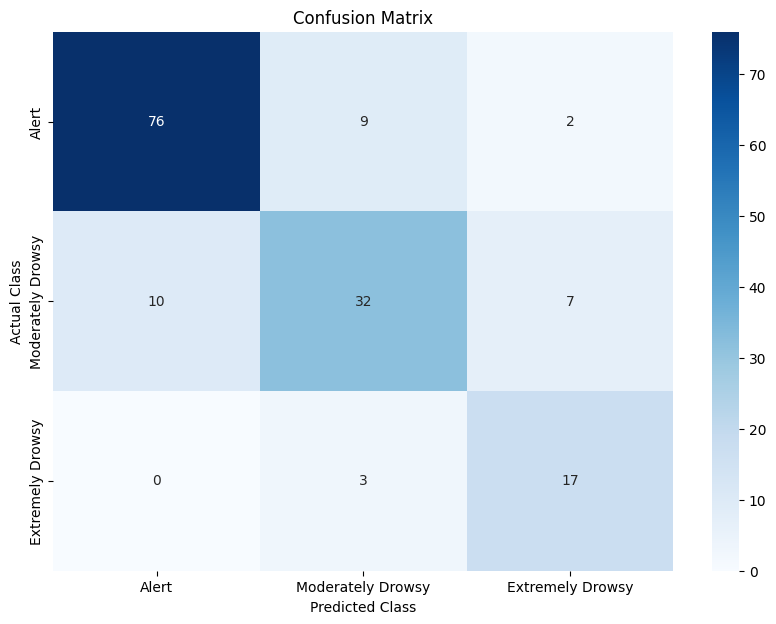

In [86]:
y_hat2 = model2.predict(X_test_scaled)
y_hat2_classes = np.argmax(y_hat2, axis=1)
y_test_compare = y_test-1

import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(y_test_compare, y_hat2_classes)
def plot_confusion_matrix(cm, class_names):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()

class_names = ['Alert', 'Moderately Drowsy', 'Extremely Drowsy']
# Assuming 'class_names' is a list of your class names, such as class_names = ['Class1', 'Class2', 'Class3']
plot_confusion_matrix(cm, class_names)

In [87]:
# Predict the test set
predictions = model2.predict(X_test_scaled)
predicted_classes = np.argmax(predictions, axis=1)


# True classes (convert from one-hot if necessary)
true_classes = np.argmax(y_test_encoded, axis=1)  # Make sure y_encoded is not class indices

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:\n", conf_matrix)

# Class-wise accuracy
class_wise_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
print("Class-wise Accuracy:", class_wise_accuracy)

# Detailed classification report
if numClasses == 3:
    report = classification_report(true_classes, predicted_classes, target_names=['Class0', 'Class1', 'Class2'])
elif numClasses == 2:
    report = classification_report(true_classes, predicted_classes, target_names=['Class0', 'Class1'])

print(report)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Confusion Matrix:
 [[76  9  2]
 [10 32  7]
 [ 0  3 17]]
Class-wise Accuracy: [0.87356322 0.65306122 0.85      ]
              precision    recall  f1-score   support

      Class0       0.88      0.87      0.88        87
      Class1       0.73      0.65      0.69        49
      Class2       0.65      0.85      0.74        20

    accuracy                           0.80       156
   macro avg       0.75      0.79      0.77       156
weighted avg       0.81      0.80      0.80       156



5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - accuracy: 0.8383 - loss: 0.5397
Test Accuracy: 0.8012820482254028, Test Loss: 0.6280327439308167


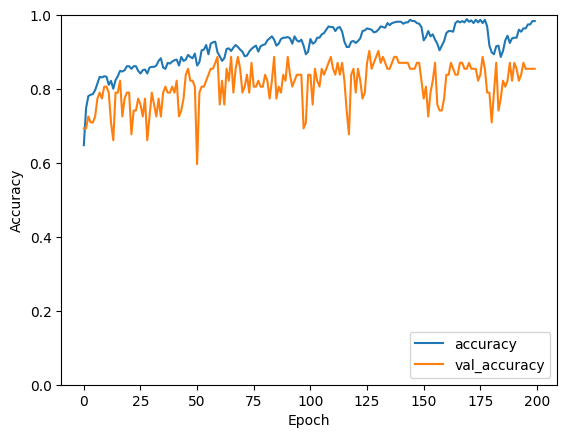

In [88]:
# Evaluate the model
test_loss, test_acc = model2.evaluate(X_test_scaled, y_test-1)
print(f"Test Accuracy: {test_acc}, Test Loss: {test_loss}")

# Plot training history
import matplotlib.pyplot as plt

plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

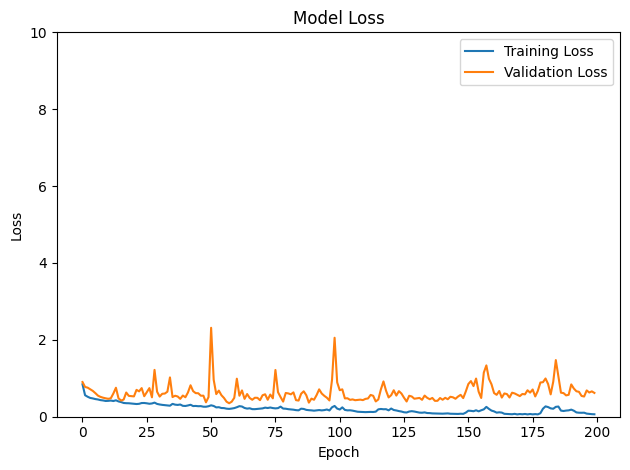

In [89]:
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss') 
plt.ylim([0, 10])
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

## **6. Model Testing (new cases)**

##### **6.1 Import Data**

In [91]:
# subject_test = str(input('Testing data fro m subject: '))
print('Testing data: Subject', str(subject_test))

Testing data: Subject 7


In [92]:
EEG_features_allcases = []
ECG_features_allcases = []
ord_60min_allcases = []
channelList_allcases = []

ECG_features, EEG_features, ord_60min, channelList = load_subject_data(int(subject_test))
EEG_features_allcases.append(EEG_features)
ECG_features_allcases.append(ECG_features)
ord_60min_allcases.append(ord_60min)
channelList_allcases.append(channelList)



In [93]:
ECG_field_names = ECG_features.dtype.names
EEG_field_names = EEG_features.dtype.names
print('Loaded Data')
print('ECG Features: ', ECG_field_names) # data stored in 'ECG_features'
print('EEG Features: ', EEG_field_names) # data stored in 'EEG_features'

Loaded Data
ECG Features:  ('Index', 'ECG', 'ECGTimestamps', 'RRI', 'RRITimestamps', 'VLF', 'LF', 'HF', 'LFHF', 'RPeakTimestamps', 'pLF', 'pHF')
EEG Features:  ('Epoch', 'TotalPower', 'AlphaPower', 'AlphaRelative', 'ThetaPower', 'ThetaRelative', 'BetaPower1', 'BetaPower2', 'RBR', 'BetaPower', 'BetaRelative', 'DeltaPower', 'DeltaRelative', 'AlphaBetaRatio', 'TA_BRatio')


In [94]:
# EEG_channel_list = []

# while True:
#     channel = input('training channel: ')
#     if channel == '':
#         break  # Exit the loop if no input is provided and just Enter is pressed.
#     else:
#         try:
#             # Convert the input to an integer and add it to the list
#             channel_number = int(channel)
#             EEG_channel_list.append(channel_number)
#         except ValueError:
#             # Handle the case where the input is not an integer
#             print("Please enter a valid number or press Enter to finish.")

# print("Channels entered:", EEG_channel_list)

EEG_channel_train = ''.join(str(x) for x in EEG_channel_list)
print(EEG_channel_train)


3


In [95]:
initial_kss = [7, 6, 5, 5, 5, 5, 5, 7, 6, 4, 5, 6, 7, 6, 5]

In [96]:
ECG_features_df = ECG_dataframe(0, ECG_features_allcases) # ECG_features_df
    
EEG_features_df_list = EEG_dataframe_list(0, EEG_features_allcases, channelList_allcases) # EEG_features_df_list
    # EEG_features_df = EEG_features_df_list[EEG_channel-1] # Features from Channel 1
EEG_features_df = pd.DataFrame()

for EEG_channel in EEG_channel_list:
    EEG_features_append = EEG_features_df_list[EEG_channel-1].copy() # Features from Channel 1
    EEG_features_append.columns = [f'{col}_{EEG_channel}' for col in EEG_features_append.columns]
    EEG_features_df = pd.concat([EEG_features_df, EEG_features_append], axis=1)
    
ord_epoch = ord_dataframe(0, ord_60min_allcases, numClasses)
    
print(ord_epoch['class name'].value_counts())

combined_data = combined_dataframe(EEG_features_df, ECG_features_df, ord_epoch)
# combined_data = combined_dataframe(ECG_features_df, ord_epoch)
combined_data.insert(1, 'Initial_KSS', initial_kss[int(subject_test)-1])


combined_data = combined_data.dropna()

display(combined_data)

class name
Moderately Drowsy    74
Alert                36
Extremely Drowsy      9
Name: count, dtype: int64


,Epoch_minute,Initial_KSS,DeltaRelative_3,ThetaRelative_3,AlphaRelative_3,BetaRelative_3,AlphaBetaRatio_3,TA_BRatio_3,VLF,LF,HF,LFHF,pLF,pHF,ORD class,class name
0,1.0,5,0.809615,0.100088,0.043567,0.044671,0.975265,3.215801,0.358265,1.102917,0.616249,1.789727,64.154200,35.845800,1.0,Alert
1,1.5,5,0.792569,0.111111,0.053851,0.042349,1.271589,3.895255,0.303801,0.886317,0.824599,1.074846,51.803651,48.196349,1.0,Alert
2,2.0,5,0.782923,0.101976,0.063684,0.048873,1.303068,3.389644,1.041146,0.548323,0.462087,1.186622,54.267350,45.732650,1.0,Alert
3,2.5,5,0.845596,0.084367,0.040636,0.030246,1.343526,4.132880,0.469883,0.909964,0.654749,1.389791,58.155344,41.844656,1.0,Alert
4,3.0,5,0.850165,0.080598,0.043285,0.025066,1.726848,4.942289,0.441374,1.324003,0.347841,3.806341,79.194152,20.805848,1.0,Alert
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,58.0,5,0.767012,0.103791,0.076956,0.053555,1.436954,3.374992,1.022807,0.569930,0.478651,1.190703,54.352543,45.647457,2.0,Moderately Drowsy
115,58.5,5,0.741962,0.114125,0.084110,0.057280,1.468405,3.460820,0.440881,1.490997,0.202128,7.376498,88.061837,11.938163,2.0,Moderately Drowsy
116,59.0,5,0.751298,0.122404,0.064071,0.061107,1.048512,3.051622,0.343341,1.612073,0.170341,9.463822,90.443263,9.556737,2.0,Moderately Drowsy
117,59.5,5,0.757090,0.109241,0.063436,0.067877,0.934574,2.543979,0.918173,1.006392,0.177527,5.668960,85.005159,14.994841,2.0,Moderately Drowsy


##### **6.2 Data Preparation**

In [97]:
combined_data.head()

,Epoch_minute,Initial_KSS,DeltaRelative_3,ThetaRelative_3,AlphaRelative_3,BetaRelative_3,AlphaBetaRatio_3,TA_BRatio_3,VLF,LF,HF,LFHF,pLF,pHF,ORD class,class name
0,1.0,5,0.809615,0.100088,0.043567,0.044671,0.975265,3.215801,0.358265,1.102917,0.616249,1.789727,64.154200,35.845800,1.0,Alert
1,1.5,5,0.792569,0.111111,0.053851,0.042349,1.271589,3.895255,0.303801,0.886317,0.824599,1.074846,51.803651,48.196349,1.0,Alert
2,2.0,5,0.782923,0.101976,0.063684,0.048873,1.303068,3.389644,1.041146,0.548323,0.462087,1.186622,54.267350,45.732650,1.0,Alert
3,2.5,5,0.845596,0.084367,0.040636,0.030246,1.343526,4.132880,0.469883,0.909964,0.654749,1.389791,58.155344,41.844656,1.0,Alert
4,3.0,5,0.850165,0.080598,0.043285,0.025066,1.726848,4.942289,0.441374,1.324003,0.347841,3.806341,79.194152,20.805848,1.0,Alert


In [98]:
# INPUT: Epoch_minute + EEG features + ECG features
# X = combined_data.iloc[:, 0:13].copy()
# X = combined_data.iloc[:, [0, 1, 2, 3, 4, 5, 6, 10, 11, 12]].copy()

X = combined_data.loc[:, ~combined_data.columns.isin(excluded_columns)].copy()

print(X.shape)
X.head()

(119, 10)


,Epoch_minute,DeltaRelative_3,ThetaRelative_3,AlphaRelative_3,BetaRelative_3,AlphaBetaRatio_3,TA_BRatio_3,LFHF,pLF,pHF
0,1.0,0.809615,0.100088,0.043567,0.044671,0.975265,3.215801,1.789727,64.154200,35.845800
1,1.5,0.792569,0.111111,0.053851,0.042349,1.271589,3.895255,1.074846,51.803651,48.196349
2,2.0,0.782923,0.101976,0.063684,0.048873,1.303068,3.389644,1.186622,54.267350,45.732650
3,2.5,0.845596,0.084367,0.040636,0.030246,1.343526,4.132880,1.389791,58.155344,41.844656
4,3.0,0.850165,0.080598,0.043285,0.025066,1.726848,4.942289,3.806341,79.194152,20.805848


In [99]:
# OUTPUT: ORD class
y = combined_data['ORD class'].copy()
print(y.shape)
y.head()

(119,)


0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: ORD class, dtype: float64

In [100]:
class_counts = y.value_counts()
print(class_counts)

ORD class
2.0    74
1.0    36
3.0     9
Name: count, dtype: int64


In [101]:
if data_scaling == 0:
    X_scaled = X

elif data_scaling == 1:
    X_scaled = scale(X)

elif data_scaling == 2:
    X_scaled = scaler.transform(X)

elif data_scaling == 3:
    X_scaled = scaler.transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=transformed_columns)
    X_scaled = X_scaled[X.columns]

elif data_scaling == 4:
    X_scaled = scaler.transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=transformed_columns)
    X_scaled = X_scaled[X.columns]

#### **6.3 Model Test**

In [102]:
# X_encoded = pd.get_dummies(X_scaled).values
# y_encoded = pd.get_dummies(y).values
y_encoded = encoder.transform(pd.DataFrame(y))

- **categorical_crossentropy**

In [103]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_scaled, y_encoded)
print(f"Test Accuracy: {test_acc}, Test Loss: {test_loss}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9017 - loss: 0.5893 
Test Accuracy: 0.8739495873451233, Test Loss: 0.9576341509819031


In [104]:
# Predict the test set
predictions = model.predict(X_scaled)
predicted_classes = np.argmax(predictions, axis=1)

# True classes (convert from one-hot if necessary)
true_classes = np.argmax(y_encoded, axis=1)  # Make sure y_encoded is not class indices

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:\n", conf_matrix)

# Class-wise accuracy
class_wise_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
print("Class-wise Accuracy:", class_wise_accuracy)

# Detailed classification report
if numClasses == 3:
    report = classification_report(true_classes, predicted_classes, target_names=['Class0', 'Class1', 'Class2'])
elif numClasses == 2:
    report = classification_report(true_classes, predicted_classes, target_names=['Class0', 'Class1'])

print(report)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Confusion Matrix:
 [[34  2  0]
 [ 6 66  2]
 [ 1  4  4]]
Class-wise Accuracy: [0.94444444 0.89189189 0.44444444]
              precision    recall  f1-score   support

      Class0       0.83      0.94      0.88        36
      Class1       0.92      0.89      0.90        74
      Class2       0.67      0.44      0.53         9

    accuracy                           0.87       119
   macro avg       0.80      0.76      0.77       119
weighted avg       0.87      0.87      0.87       119



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


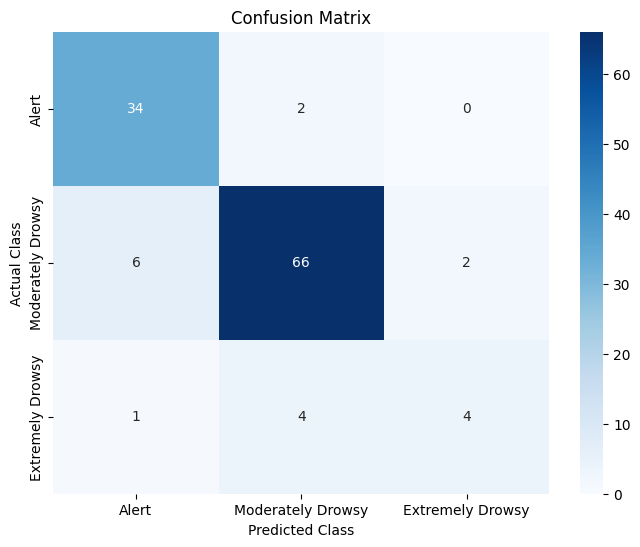

In [105]:
y_hat = model.predict(X_scaled)
y_hat_classes = np.argmax(y_hat, axis=1)
y_compare = y-1

import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(y_compare, y_hat_classes)
def plot_confusion_matrix(cm, class_names):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()

if numClasses == 3:
    class_names = ['Alert', 'Moderately Drowsy', 'Extremely Drowsy']
elif numClasses == 2:
    class_names = ['Alert', 'Drowsy']
# Assuming 'class_names' is a list of your class names, such as class_names = ['Class1', 'Class2', 'Class3']
plot_confusion_matrix(cm, class_names)

- **sparse_categorical_crossentropy**

In [106]:
# Evaluate the model
test_loss, test_acc = model2.evaluate(X_scaled, y-1)
print(f"Test Accuracy: {test_acc}, Test Loss: {test_loss}")



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5931 - loss: 3.5408 
Test Accuracy: 0.42016807198524475, Test Loss: 6.337536811828613


In [107]:
# Predict the test set
predictions = model2.predict(X_scaled)
predicted_classes = np.argmax(predictions, axis=1)

# True classes (convert from one-hot if necessary)
true_classes = np.argmax(y_encoded, axis=1)  # Make sure y_encoded is not class indices

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:\n", conf_matrix)

# Class-wise accuracy
class_wise_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
print("Class-wise Accuracy:", class_wise_accuracy)

# Detailed classification report
if numClasses == 3:
    report = classification_report(true_classes, predicted_classes, target_names=['Class0', 'Class1', 'Class2'])
elif numClasses == 2:
    report = classification_report(true_classes, predicted_classes, target_names=['Class0', 'Class1'])
print(report)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Confusion Matrix:
 [[35  1  0]
 [59 15  0]
 [ 8  1  0]]
Class-wise Accuracy: [0.97222222 0.2027027  0.        ]
              precision    recall  f1-score   support

      Class0       0.34      0.97      0.51        36
      Class1       0.88      0.20      0.33        74
      Class2       0.00      0.00      0.00         9

    accuracy                           0.42       119
   macro avg       0.41      0.39      0.28       119
weighted avg       0.65      0.42      0.36       119



c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


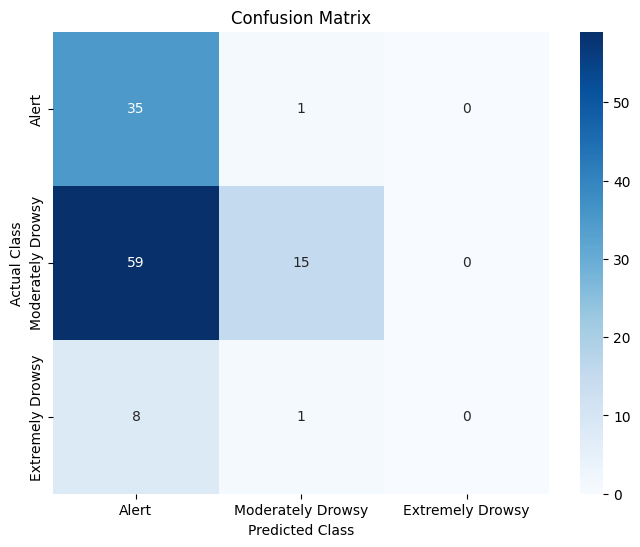

In [108]:
y_hat2 = model2.predict(X_scaled)
y_hat2_classes = np.argmax(y_hat2, axis=1)
y_compare = y-1

import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(y_compare, y_hat2_classes)
def plot_confusion_matrix(cm, class_names):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()

if numClasses == 3:
    class_names = ['Alert', 'Moderately Drowsy', 'Extremely Drowsy']
elif numClasses == 2:
    class_names = ['Alert', 'Drowsy']
# Assuming 'class_names' is a list of your class names, such as class_names = ['Class1', 'Class2', 'Class3']
plot_confusion_matrix(cm, class_names)

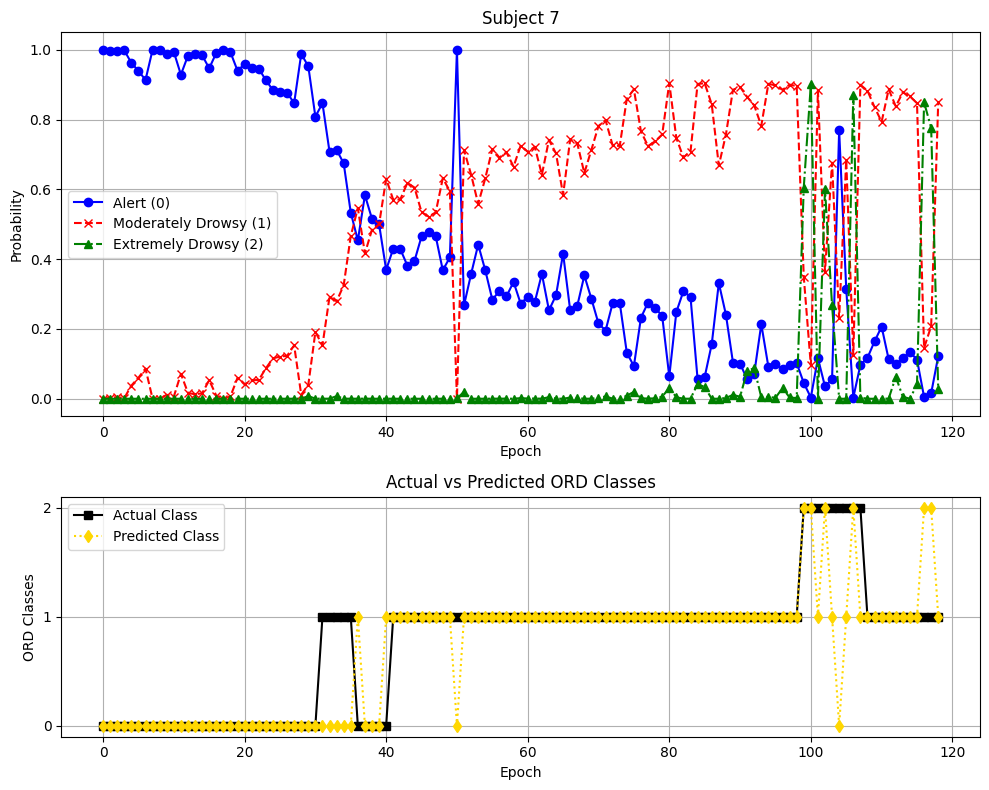

In [109]:
new_y = pd.DataFrame()
new_y['ord'] = (y-1)
new_y['score0'] = y_hat[:, 0]
new_y['score1'] = y_hat[:, 1]
new_y['score2'] = y_hat[:, 2]
new_y['predicted_ord'] = (y_hat_classes)


# Create figure and subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [1.6, 1]})

# First subplot
axs[0].plot(new_y['score0'], label='Alert (0)', marker='o', linestyle='-', color='b')
axs[0].plot(new_y['score1'], label='Moderately Drowsy (1)', marker='x', linestyle='--', color='r')
axs[0].plot(new_y['score2'], label='Extremely Drowsy (2)', marker='^', linestyle='-.', color='g')
axs[0].set_title(f'Subject {subject_test}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Probability')
axs[0].legend()
axs[0].grid(True)

# Second subplot
axs[1].plot(new_y['ord'], label='Actual Class', marker='s', linestyle='-', color='black')
axs[1].plot(new_y['predicted_ord'], label='Predicted Class', marker='d', linestyle=':', color='gold')
axs[1].set_title('Actual vs Predicted ORD Classes')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('ORD Classes')
axs[1].set_yticks([0, 1, 2])  # Set y-axis to show only 0, 1, 2
axs[1].legend()
axs[1].grid(True)

# Adjust subplot parameters
plt.subplots_adjust(hspace=0.3)  # Adjust horizontal space if needed

plt.tight_layout()
plt.show()